In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import chain
import matplotlib.pyplot as plt

from metapaths.tools import obo_tools as ot
from metapaths.tools.processing import expand_col_on_char, expand_split_col, expand_df_on_col, load_api_results
from hetnet_ml.src import graph_tools as gt


data_dir = Path('../2_pipeline/00_download_data/out/').resolve()
this_name = '10_Inter-Ontology_Edges'
out_dir = Path('../2_pipeline/').joinpath(this_name).joinpath('out').resolve()

In [2]:
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Load the ontologies to be examined

In [3]:
pr_edges = ot.get_ontology_edges(data_dir.joinpath('pr.obo'))
cl_edges = ot.get_ontology_edges(data_dir.joinpath('cl.obo'))
chebi_edges = ot.get_ontology_edges(data_dir.joinpath('chebi.obo'))
ub_edges = ot.get_ontology_edges(data_dir.joinpath('ext.obo'))
hp_edges = ot.get_ontology_edges(data_dir.joinpath('hpo.obo'))
go_nodes, go_edges = ot.get_go_nodes_and_edges(data_dir.joinpath('go-plus.json'))

In [4]:
hp_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,HP:0000002,Abnormality of body height,is_a,HP:0001507,Growth abnormality,HP,HP
1,HP:0000003,Multicystic kidney dysplasia,is_a,HP:0000107,Renal cyst,HP,HP


### Look at inter-ontology edges to see how things are connected

In [5]:
all_onto_edges = pd.concat([pr_edges, cl_edges, chebi_edges, ub_edges, hp_edges, go_edges], 
                           ignore_index=True, sort=False)

all_onto_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),is_a,SO:0001217,protein_coding_gene,Araport,SO
1,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),only_in_taxon,NCBITaxon:3702,Arabidopsis thaliana,Araport,NCBITaxon


In [6]:
examined_ontos = ['CHEBI', 'CL', 'PR', 'UBERON', 'HPO', 'GO']
q_res = all_onto_edges.query('src_src != tgt_src and src_src in @examined_ontos and tgt_src in @examined_ontos')
m_edges = []
for row in q_res.itertuples():
    m_edges.append((row.src_src, row.tgt_src))
pair_counts = pd.Series(m_edges).value_counts()
pair_counts

(GO, CHEBI)        5881
(CL, UBERON)       1604
(GO, UBERON)       1308
(CL, PR)           1225
(PR, GO)           1167
(GO, CL)           1063
(CL, GO)            899
(UBERON, GO)        669
(UBERON, CL)        572
(GO, PR)            362
(PR, CHEBI)         351
(UBERON, CHEBI)      57
(UBERON, PR)         19
(CHEBI, PR)           5
(CL, CHEBI)           2
dtype: int64

In [7]:
pairs = pair_counts.index.tolist()
frac = 0.03
min_counts = 100

for pair in pairs:
    # Only look at pariings with a significant number of edges
    if pair_counts[pair] < min_counts:
        continue
    
    # Print the top relationship types that link two concept types
    print('\n{} ---> {}\n'.format(*pair))
    rels = q_res.query('src_src == {!r} and tgt_src == {!r}'.format(*pair))['rel_type']
    counts = rels.value_counts()
    print(counts[counts > len(rels)*frac])
    print('\n\n'+'-'*40)    


GO ---> CHEBI

has_primary_input_or_output                1277
has_primary_output                         1163
has_primary_input                           994
has_input                                   957
transports_or_maintains_localization_of     954
imports                                     178
Name: rel_type, dtype: int64


----------------------------------------

CL ---> UBERON

part_of    1555
Name: rel_type, dtype: int64


----------------------------------------

GO ---> UBERON

results_in_development_of      587
results_in_morphogenesis_of    340
results_in_formation_of        174
occurs_in                       70
results_in_maturation_of        53
Name: rel_type, dtype: int64


----------------------------------------

CL ---> PR

lacks_plasma_membrane_part         456
has_plasma_membrane_part           450
has_part                           166
has_low_plasma_membrane_amount      72
has_high_plasma_membrane_amount     65
Name: rel_type, dtype: int64


----------------

## Choosing edge types to process

`is_a` relationships, or those with very low counts are not super interesting
Based on this analysis, we will keep the following cross-ontology references...

- CL to PR
- ######PR to GO#### Only seems to be output_of protein processing... or is_a complex... we will skip
- CL to UBERON
- CL to GO 
- UBERON to GO
- UBERON to CL
- GO to CHEBI
- GO to UBERON
- GO to CL

## PR processing

PR is structured interestingly in that there are protein classes (identifiers that begein with PR:000xxxxxxx) and proteins (which have PR:{Uniprot ID}). Ournetwork already has classes of proteins from interpro... However, most cross ontologies link to these class nodes.  Class nodes tcan then be madded to uniprot nodes, so we can get direct mappings from other ontologies (like CL) to Uniprot by using these.

PR also has proteins from many different species.  We are primarly interested in either human proteins, or proteins of infectious diseeases, so we will filter out taxa that do not fit into those categories.

In [8]:
pr_nodes = ot.get_ontology_nodes(data_dir.joinpath('pr.obo'))
print(len(pr_nodes))
pr_nodes.head(2)

316242


,alt_id,def,id,is_obsolete,name,replaced_by,xref,id_src
0,NaN,"""A protein coding gene NAC001 in Arabidopsis t...",Araport:AT1G01010,False,NAC001 (Arabidopsis thaliana),NaN,NaN,Araport
1,NaN,"""A protein coding gene NGA3 in Arabidopsis tha...",Araport:AT1G01030,False,NGA3 (Arabidopsis thaliana),NaN,NaN,Araport


In [9]:
pr_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),is_a,SO:0001217,protein_coding_gene,Araport,SO
1,Araport:AT1G01010,NAC001 (Arabidopsis thaliana),only_in_taxon,NCBITaxon:3702,Arabidopsis thaliana,Araport,NCBITaxon


In [10]:
idx = pr_edges.query('rel_type == "only_in_taxon"').index
pr_edges.loc[idx, 'tax_id'] = pr_edges.loc[idx, 'tgt_id'].str.split(':', expand=True)[1].astype(int)

In [11]:
# Placehoder for now. Once infectious taxa are sorted out we will add
infectious_taxa = [1450427, 12721] #e-coli and hiv

In [12]:
from biothings_client import get_client
mt = get_client('taxon')

ok_taxa = set(mt.gettaxon(9606)['lineage'])

for t in infectious_taxa:
    ok_taxa.update(set(mt.gettaxon(t)['lineage']))

Filter out unneded taxa first

In [13]:
other_proteins = pr_edges.query('rel_type == "only_in_taxon" and tax_id not in @ok_taxa')['src_id'].unique()
len(other_proteins)

194975

In [14]:
# Prefixes on human proteins
ok_prefix = pr_edges.query('rel_type == "only_in_taxon" and tax_id in @ok_taxa')['src_src'].unique()
ok_prefix

array(['HGNC', 'NCBIGene', 'PR'], dtype=object)

In [15]:
print(len(pr_nodes))
ok_pr_nodes = pr_nodes.query('id not in @other_proteins').copy()
print(len(ok_pr_nodes))

316242
121267


In [16]:
ok_pr_nodes['id_src'].unique()

array(['BFO', 'CHEBI', 'GO', 'HGNC', 'MOD', 'NCBIGene', 'NCBITaxon',
       'OBI', 'PR', 'SO'], dtype=object)

In [17]:
ok_pr_nodes = ok_pr_nodes.query('id_src in @ok_prefix').copy()
ok_pr_nodes.head(2)

,alt_id,def,id,is_obsolete,name,replaced_by,xref,id_src
25960,NaN,"""A protein coding gene ASIC1 in human."" [PRO:DNx]",HGNC:100,False,ASIC1 (human),NaN,NaN,HGNC
25961,NaN,"""A protein coding gene RGS4 in human."" [PRO:DNx]",HGNC:10000,False,RGS4 (human),NaN,NaN,HGNC


In [18]:
ok_pr_nodes.query('id_src == "NCBIGene"').sample(5)

,alt_id,def,id,is_obsolete,name,replaced_by,xref,id_src
67097,NaN,"""A protein coding gene HDGFRP2 in human."" [PRO...",NCBIGene:84717,False,HDGFRP2 (human),NaN,NaN,NCBIGene
63579,NaN,"""A protein coding gene SGK223 in human."" [PRO:...",NCBIGene:157285,False,SGK223 (human),NaN,NaN,NCBIGene
63699,NaN,"""A protein coding gene plasmid pC15-1a blaTEM-...",NCBIGene:2716540,False,plasmid pC15-1a blaTEM-1 (Escherichia coli),NaN,NaN,NCBIGene
63528,NaN,"""A protein coding gene plasmid pXZ blaTEM-1 in...",NCBIGene:13906924,False,plasmid pXZ blaTEM-1 (Escherichia coli),NaN,NaN,NCBIGene
66569,NaN,"""A protein coding gene SELT in human."" [PRO:DNx]",NCBIGene:51714,False,SELT (human),NaN,NaN,NCBIGene


In [19]:
pr_edges.query('src_id in {}'.format(ok_pr_nodes.query('id_src == "NCBIGene"')['id'].values.tolist())).head(6)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tax_id
125235,NCBIGene:100129307,LOC100129307 (human),is_a,SO:0001217,protein_coding_gene,NCBIGene,SO,NaN
125236,NCBIGene:100129307,LOC100129307 (human),only_in_taxon,NCBITaxon:9606,Homo sapiens,NCBIGene,NCBITaxon,9606.0
125237,NCBIGene:100131107,LOC100131107 (human),is_a,SO:0001217,protein_coding_gene,NCBIGene,SO,NaN
125238,NCBIGene:100131107,LOC100131107 (human),only_in_taxon,NCBITaxon:9606,Homo sapiens,NCBIGene,NCBITaxon,9606.0
125381,NCBIGene:10076131,plasmid p3521 blaTEM-1 copy 1 (Escherichia coli),is_a,SO:0001217,protein_coding_gene,NCBIGene,SO,NaN
125382,NCBIGene:10076131,plasmid p3521 blaTEM-1 copy 1 (Escherichia coli),only_in_taxon,NCBITaxon:562,Escherichia coli,NCBIGene,NCBITaxon,562.0


In [20]:
pr_edges.query('src_id in {}'.format(ok_pr_nodes.query('id_src == "NCBIGene"')['id'].values.tolist()))['tgt_name'].value_counts()

protein_coding_gene    68
Escherichia coli       48
Homo sapiens           20
Name: tgt_name, dtype: int64

Unneded edges

In [21]:
pr_edges.query('src_id in {}'.format(ok_pr_nodes.query('id_src == "HGNC"')['id'].values.tolist()))['tgt_name'].value_counts()

Homo sapiens           19793
protein_coding_gene    19793
Name: tgt_name, dtype: int64

More Unneded-edges...

Looks like only the `PR` nodes are useful to us

In [22]:
ok_pr_nodes = ok_pr_nodes.query('id_src == "PR"').copy()
ok_pr_nodes.sample(5)

,alt_id,def,id,is_obsolete,name,replaced_by,xref,id_src
105064,NaN,"""A 5-hydroxytryptamine receptor 1B that is a t...",PR:000039194,False,5-hydroxytryptamine receptor 1B isoform 1,NaN,NaN,PR
71999,NaN,"""A protein that is a translation product of th...",PR:000003608,False,"Arf-GAP with coiled-coil, ANK repeat and PH do...",NaN,NaN,PR
80025,NaN,"""A class II olfactory receptor that is a trans...",PR:000011711,False,olfactory receptor 14C36,NaN,NaN,PR
269248,NaN,"""A tropomodulin-2 that is encoded in the genom...",PR:Q9NZR1,False,tropomodulin-2 (human),NaN,"Reactome:R-HSA-5694032 ""PR:Q9NZR1 located_in G...",PR
165630,NaN,"""A serine/threonine-protein phosphatase 5 that...",PR:P53041,False,serine/threonine-protein phosphatase 5 (human),NaN,UniProtKB:P53041,PR


In [23]:
ok_pr_ids = ok_pr_nodes['id'].unique()
ok_pr_edges = pr_edges.query('src_id in @ok_pr_ids').copy()
len(ok_pr_edges)

222132

#### Separate the Protein Classes from the actual proteins with uniprot ids

In [24]:
ok_pr_nodes['id_part'] = ok_pr_nodes['id'].str.split(':', expand=True)[1]

In [25]:
pr_ids = ok_pr_nodes['id_part'].str.startswith('000')
ok_pr_nodes[pr_ids].sample(5)

,alt_id,def,id,is_obsolete,name,replaced_by,xref,id_src,id_part
100058,NaN,"""A protein that is a translation product of th...",PR:000033391,False,phosphotransferase IIA component SgcA,NaN,NaN,PR,000033391
94237,NaN,"""A unique cartilage matrix-associated protein ...",PR:000026355,False,unique cartilage matrix-associated protein iso...,NaN,NaN,PR,000026355
99145,NaN,"""A protein that is a translation product of th...",PR:000032329,False,uncharacterized protein DNAH10OS,NaN,NaN,PR,000032329
73776,NaN,"""A protein that is a translation product of th...",PR:000005393,False,cingulin,NaN,NaN,PR,000005393
114942,NaN,"""A 60S ribosomal protein L37a (human) that has...",PR:000049088,False,"60S ribosomal protein L37a, initiator methioni...",NaN,"Reactome:R-HSA-72468 ""PR:000049088 located_in ...",PR,000049088


In [26]:
other_ids = ok_pr_nodes[~pr_ids]['id'].unique()
pr_ids = ok_pr_nodes[pr_ids]['id'].unique()

Our network already has most of the IDs in Entrezgene space... so we need to map from uniprot to entrez

In [27]:
# These are the ids that we're going to need to map to entrezgene
ok_pr_edges.query('src_id in @other_ids and rel_type == "is_a"').sample(10)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tax_id
674011,PR:Q9NP92,"39S ribosomal protein S30, mitochondrial (human)",is_a,PR:000010637,"39S ribosomal protein S30, mitochondrial",PR,PR,NaN
422698,PR:Q14CN4-1,"keratin, type II cytoskeletal 72 isoform h1 (h...",is_a,PR:Q14CN4,"keratin, type II cytoskeletal 72 (human)",PR,PR,NaN
423722,PR:Q15323-1,"keratin, type I cuticular Ha1 isoform 1 (human)",is_a,PR:Q15323,"keratin, type I cuticular Ha1 (human)",PR,PR,NaN
363780,PR:P51685-1,C-C chemokine receptor type 8 isoform h1 (human),is_a,PR:P51685,C-C chemokine receptor type 8 (human),PR,PR,NaN
422653,PR:Q14CB8-2,Rho GTPase-activating protein 19 isoform h2 (h...,is_a,PR:Q14CB8,Rho GTPase-activating protein 19 (human),PR,PR,NaN
698430,PR:Q9UHV5-1,Rap guanine nucleotide exchange factor-like 1 ...,is_a,PR:000043899,Rap guanine nucleotide exchange factor-like 1 ...,PR,PR,NaN
419226,PR:Q13588-1,GRB2-related adapter protein isoform 1 (human),is_a,PR:000040458,GRB2-related adapter protein isoform 1,PR,PR,NaN
626492,PR:Q9BWV3-2,cytidine and dCMP deaminase domain-containing ...,is_a,PR:Q9BWV3,cytidine and dCMP deaminase domain-containing ...,PR,PR,NaN
426981,PR:Q17RB0,retrotransposon Gag-like protein 8B (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,NaN
677892,PR:Q9NW38,E3 ubiquitin-protein ligase FANCL (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,NaN


In [28]:
to_query = [p.split(':')[1] for p in other_ids]
len(to_query)

54708

In [29]:
to_query = set([q.split('-')[0] for q in to_query])
len(to_query)

20026

In [30]:
mg = get_client('gene')
qres = load_api_results('mg_pr_query_res_{}.pkl', re_scrape=False, scrape_function=mg.querymany, qterms=to_query, 
                        scopes='uniprot,accession.protein', fields='entrezgene,name,taxid,symbol,uniprot',
                        size=10)
len(qres)

20775

In [31]:
import collections
import six


def iterable(arg):
    return isinstance(arg, collections.Iterable) and not isinstance(arg, six.string_types)


def process_inner(res, key, base_key):
    new_key = base_key+'.'+key
    new_key = new_key.lower().replace(' ', '_').replace('-', '_')

    out = res.get(base_key, dict()).get(key)
    if iterable(out):
        out = '|'.join(out)
    return new_key, out
        


for res in qres:
    k, v = process_inner(res, 'Swiss-Prot', 'uniprot')
    res[k] = v
    k, v = process_inner(res, 'TrEMBL', 'uniprot')
    res[k] = v

df = pd.DataFrame(qres)
df = df.drop('uniprot', axis=1)
len(df)

20775

In [32]:
df.head(2)

,_id,_score,entrezgene,name,notfound,query,symbol,taxid,uniprot.swiss_prot,uniprot.trembl
0,435,14.439482,435,argininosuccinate lyase,NaN,P04424,ASL,9606.0,P04424,A0A0S2Z316|A0A024RDL8|F8W943
1,254439,30.326424,254439,chromosome 11 open reading frame 86,NaN,A6NJI1,C11orf86,9606.0,A6NJI1,None


In [33]:
df.count()

_id                   20527
_score                20527
entrezgene            20166
name                  20527
notfound                248
query                 20775
symbol                20527
taxid                 20527
uniprot.swiss_prot    19779
uniprot.trembl        15292
dtype: int64

In [34]:
df.nunique()

_id                   20231
_score                 5938
entrezgene            19870
name                  19865
notfound                  1
query                 20026
symbol                19876
taxid                     8
uniprot.swiss_prot    19154
uniprot.trembl        14985
dtype: int64

In [35]:
coverage = df.drop_duplicates(subset=['query'])['entrezgene'].nunique() / df['query'].nunique()
"Uniprot to entrez mapping success: {:3.2%}".format(coverage)

'Uniprot to entrez mapping success: 98.03%'

In [36]:
uni_to_entrez = df.dropna(subset=['entrezgene'])[['query', 'entrezgene']]
uni_to_entrez['pr_id'] = 'PR:' + uni_to_entrez['query']

In [37]:
uni_to_entrez.sample(10)

,query,entrezgene,pr_id
4734,Q2KJY2,55083,PR:Q2KJY2
1722,O75563,8935,PR:O75563
19795,Q9NRA0,56848,PR:Q9NRA0
15814,Q96GV9,90355,PR:Q96GV9
17241,O75310,10720,PR:O75310
18263,Q8N3Y7,195814,PR:Q8N3Y7
5545,O95257,10912,PR:O95257
15060,P58418,7401,PR:P58418
13845,P0C6S8,645191,PR:P0C6S8
7601,A0A0A6YYK6,28667,PR:A0A0A6YYK6


## is_a from PR to entrez

In [38]:
ok_pr_edges.query('rel_type == "is_a" and src_id in @other_ids and tgt_id in @pr_ids')['tgt_name'].nunique()

24503

In [39]:
uniprot_to_pr = ok_pr_edges.query('rel_type == "is_a" and src_id in @other_ids and tgt_id in @pr_ids').copy()
uniprot_to_pr.sample(10)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tax_id
608989,PR:Q96BF6,nucleus accumbens-associated protein 2 (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,NaN
346363,PR:P39023,60S ribosomal protein L3 (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,NaN
586012,PR:Q8TF45,zinc finger protein 418 (human),is_a,PR:000017880,zinc finger protein 418,PR,PR,NaN
358776,PR:P48729,casein kinase I isoform alpha (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,NaN
626821,PR:Q9BXF3,cat eye syndrome critical region protein 2 (hu...,is_a,PR:000005314,cat eye syndrome critical region protein 2,PR,PR,NaN
697283,PR:Q9UDX5-1,mitochondrial fission process protein 1 isofor...,is_a,PR:000043854,mitochondrial 18 kDa protein isoform 1,PR,PR,NaN
318370,PR:P20711,aromatic-L-amino-acid decarboxylase (human),is_a,PR:000029067,Homo sapiens protein,PR,PR,NaN
680897,PR:Q9P107,GEM-interacting protein (human),is_a,PR:000008072,GEM-interacting protein,PR,PR,NaN
618107,PR:Q99424,peroxisomal acyl-coenzyme A oxidase 2 (human),is_a,PR:000003643,peroxisomal acyl-coenzyme A oxidase 2,PR,PR,NaN
352222,PR:P42830,C-X-C motif chemokine 5 (human),is_a,PR:000006071,C-X-C motif chemokine 5,PR,PR,NaN


# CL to PR

Now that we have a map from upper PR terms to actual entrez ids, time to map some of these intertology edges, starting with CL

In [40]:
def combine_two_onto_edges(onto1, onto2, src_src, tgt_src, common_cols=True):
    
    # Query for the source an target, concatenate, drop the duplicates.
    out = pd.concat([onto1.query('src_src == @src_src and tgt_src == @tgt_src'),
                      onto2.query('src_src == @src_src and tgt_src == @tgt_src')],
                      ignore_index=True, sort=False).drop_duplicates(subset=['src_id', 'tgt_id', 'rel_type'])
    
    if common_cols:
        cols = min([onto1.columns, onto2.columns], key=len)
        out = out[cols]
    
    return out

def edge_rename(edges, **kwargs):
    # Standard rename from ontology edges to hetnet edges
    rename_map = {'src_id': 'start_id', 'tgt_id': 'end_id', 'rel_type': 'type'}
    # Update with userdefined inputs
    rename_map.update(kwargs)
    return gt.order_cols(edges.rename(columns=rename_map))


In [41]:
cl_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,BFO:0000002,continuant,part_of,BFO:0000002,continuant,BFO,BFO
1,BFO:0000003,occurrent,part_of,BFO:0000003,occurrent,BFO,BFO


In [42]:
# Get a map from a given cl node to all its children
cl_map = ot.get_children_map(cl_edges)

In [43]:
# Some PR relationships are in cl...
cl_map['PR:000001897']

{'PR:000002023', 'PR:P26715'}

In [44]:
pr_map = ot.get_children_map(ok_pr_edges)

In [45]:
cl_to_pr = combine_two_onto_edges(cl_edges, ok_pr_edges, 'CL', 'PR')
print(len(cl_to_pr))
cl_to_pr['tgt_child'] = cl_to_pr['tgt_id'].map(pr_map).apply(list)
cl_to_pr = expand_df_on_col(cl_to_pr, 'tgt_child').dropna(subset=['tgt_child'])

1142


In [46]:
pr_in_cl = cl_to_pr['tgt_id'].unique()
len(pr_in_cl)

166

In [47]:
len([p for p in pr_in_cl if p.startswith('PR:000')])

166

Small number of unique protiens... however these represent classes... Need to map to the Uniprot IDS (which we now have mapped to entrez)

In [48]:
cur_pr_ids = []
cur_uniprot_ids = []

for pr_id in pr_in_cl:
    childs = pr_map[pr_id]
    for uni_id in childs & set(other_ids):
        cur_pr_ids.append(pr_id)
        cur_uniprot_ids.append(uni_id)
p2u_for_cl = pd.DataFrame({'pr': cur_pr_ids, 'uniprot': cur_uniprot_ids})
p2u_for_cl.sample(5)

,pr,uniprot
121,PR:000010543,PR:P05164-3
362,PR:000001841,PR:P10747-1
339,PR:000001350,PR:Q9BZS1-2
218,PR:000002972,PR:P22897-2
116,PR:000009978,PR:P02788


In [49]:
cl_to_pr = cl_to_pr.merge(p2u_for_cl, how='inner', left_on='tgt_id', right_on='pr')
cl_to_pr.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tgt_child,pr,uniprot
0,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,PR:P15391,PR:000001002,PR:P15391
1,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,PR:P15391,PR:000001002,PR:P15391-2


Those dashes after a uniqrot id represent isoforms.. however those are not represented in entrez, so we will remove them

In [50]:
cl_to_pr['uniprot_processed'] = cl_to_pr['uniprot'].apply(lambda u: u.split(':')[1].split('-')[0])
cl_to_pr.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tgt_child,pr,uniprot,uniprot_processed
0,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,PR:P15391,PR:000001002,PR:P15391,P15391
1,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,PR:P15391,PR:000001002,PR:P15391-2,P15391


In [51]:
col_name = ['entrezgene', 'name', 'query', 'symbol', 'taxid']
cl_to_pr = cl_to_pr.merge(df[col_name], left_on='uniprot_processed', right_on='query').drop_duplicates(subset=['entrezgene', 'src_id'])
cl_to_pr.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tgt_child,pr,uniprot,uniprot_processed,entrezgene,name,query,symbol,taxid
0,CL:0000037,hematopoietic stem cell,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,PR:P15391,PR:000001002,PR:P15391,P15391,930,CD19 molecule,P15391,CD19,9606.0
18,CL:0000094,granulocyte,lacks_plasma_membrane_part,PR:000001002,CD19 molecule,CL,PR,PR:P15391,PR:000001002,PR:P15391,P15391,930,CD19 molecule,P15391,CD19,9606.0


In [52]:
cl_to_pr_edges = edge_rename(cl_to_pr.drop(['tgt_child', 'pr', 'uniprot', 'query'], axis=1), 
                             name='uniprot_name', entrezgene='end_id', tgt_id='orig_tgt', 
                             tgt_name='orig_name', uniprot_processed='uniprot_id')
cl_to_pr_edges.head(2)

,start_id,end_id,type,src_name,orig_tgt,orig_name,src_src,tgt_src,uniprot_id,uniprot_name,symbol,taxid
0,CL:0000037,930,lacks_plasma_membrane_part,hematopoietic stem cell,PR:000001002,CD19 molecule,CL,PR,P15391,CD19 molecule,CD19,9606.0
18,CL:0000094,930,lacks_plasma_membrane_part,granulocyte,PR:000001002,CD19 molecule,CL,PR,P15391,CD19 molecule,CD19,9606.0


In [53]:
len(cl_to_pr_edges)

1009

In [54]:
cl_to_pr_edges['type'].value_counts()

has_plasma_membrane_part           409
lacks_plasma_membrane_part         391
has_part                            77
has_low_plasma_membrane_amount      64
has_high_plasma_membrane_amount     58
lacks_part                          10
Name: type, dtype: int64

# UBERON and CL

In [55]:
ub_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,BFO:0000004,NaN,is_a,BFO:0000002,NaN,BFO,BFO
1,BFO:0000015,NaN,is_a,BFO:0000003,NaN,BFO,BFO


In [56]:
ub_to_cl = combine_two_onto_edges(ub_edges, cl_edges, 'UBERON', 'CL')
len(ub_to_cl)

342

In [57]:
ub_to_cl.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,UBERON:0000006,islet of Langerhans,has_part,CL:0000168,insulin secreting cell,UBERON,CL
1,UBERON:0000006,islet of Langerhans,has_part,CL:0000172,somatostatin secreting cell,UBERON,CL


In [58]:
cl_to_ub = combine_two_onto_edges(ub_edges, cl_edges, 'CL', 'UBERON')
len(cl_to_ub)

924

In [59]:
cl_to_ub.head()

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,CL:0000028,CNS neuron (sensu Nematoda and Protostomia),part_of,UBERON:0001017,central nervous system,CL,UBERON
1,CL:0000047,neuronal stem cell,part_of,UBERON:0001017,central nervous system,CL,UBERON
2,CL:0000059,ameloblast,part_of,UBERON:0005176,tooth enamel organ,CL,UBERON
3,CL:0000060,odontoblast,part_of,UBERON:0005176,tooth enamel organ,CL,UBERON
4,CL:0000061,cementoblast,part_of,UBERON:0005176,tooth enamel organ,CL,UBERON


In [60]:
cl_to_ub_edges = edge_rename(cl_to_ub)
ub_to_cl_edges = edge_rename(ub_to_cl)

# GO integration

In [61]:
go_nodes.head(2)

,name,type,id,id_src,xrefs,deprecated,date,definition,subsets,synonyms,...,consider,created:by,creation:date,creator,hasAlternativeId,hasOBONamespace,hasScope,is:class:level,is:metadata:tag,shorthand
0,rhamnoside,CLASS,CHEBI:26547,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rhamnosylglucoside,CLASS,CHEBI:26548,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
go_edges.head(2)

,rel_type,src_id,src_src,src_name,tgt_id,tgt_src,tgt_name
0,is_a,CHEBI:77148,CHEBI,ginsenoside Re,GOCHE:35610,GOCHE,substance with antineoplastic agent role
1,capable_of_part_of,UBERON:0000004,UBERON,nose,GO:0007608,GO,sensory perception of smell


### CL to GO

In [63]:
cl_to_go = combine_two_onto_edges(cl_edges, go_edges, 'CL', 'GO')
print(len(cl_to_go))
go_to_cl = combine_two_onto_edges(cl_edges, go_edges, 'GO', 'CL')
print(len(go_to_cl))

486
1063


In [64]:
cl_to_go['rel_type'].value_counts().head(5)

capable_of                    292
has_plasma_membrane_part       42
has_part                       36
lacks_plasma_membrane_part     28
participates_in                18
Name: rel_type, dtype: int64

In [65]:
go_to_cl['rel_type'].value_counts().head(8)

results_in_acquisition_of_features_of    299
occurs_in                                136
results_in_development_of                 99
results_in_movement_of                    86
acts_on_population_of                     83
part_of                                   66
results_in_commitment_to                  57
has_input                                 57
Name: rel_type, dtype: int64

In [66]:
cl_to_go_edges = edge_rename(cl_to_go)
go_to_cl_edges = edge_rename(go_to_cl)

cl_to_go_edges.sample(2)

,start_id,end_id,type,src_name,tgt_name,src_src,tgt_src
366,CL:0001000,GO:0042590,capable_of,CD8_alpha-positive CD11b-negative dendritic cell,antigen processing and presentation of exogeno...,CL,GO
122,CL:0000476,GO:0070460,capable_of,thyrotroph,thyroid-stimulating hormone secretion,CL,GO


# UBERON to GO

In [67]:
ub_to_go = combine_two_onto_edges(ub_edges, go_edges, 'UBERON', 'GO')
print(len(ub_to_go))
go_to_ub = combine_two_onto_edges(ub_edges, go_edges, 'GO', 'UBERON')
print(len(go_to_ub))

417
1308


In [68]:
ub_to_go.sample(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
294,UBERON:0007627,magnocellular nucleus of stria terminalis,capable_of_part_of,GO:0043084,penile erection,UBERON,GO
337,UBERON:0011648,jaw muscle,capable_of_part_of,GO:0071626,mastication,UBERON,GO


In [69]:
go_to_ub.sample(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
1128,GO:0040003,chitin-based cuticle development,results_in_development_of,UBERON:0001001,chitin-based cuticle,GO,UBERON
319,GO:0061034,olfactory bulb mitral cell layer development,results_in_development_of,UBERON:0004186,olfactory bulb mitral cell layer,GO,UBERON


In [70]:
ub_to_go['rel_type'].value_counts().head(5)

capable_of               123
capable_of_part_of       121
has_part                  44
contains_process          28
composed_primarily_of     26
Name: rel_type, dtype: int64

In [71]:
go_to_ub['rel_type'].value_counts().head(8)

results_in_development_of                587
results_in_morphogenesis_of              340
results_in_formation_of                  174
occurs_in                                 70
results_in_maturation_of                  53
results_in_structural_organization_of     28
results_in_growth_of                      20
has_input                                  8
Name: rel_type, dtype: int64

In [72]:
ub_to_go_edges = edge_rename(ub_to_go)
go_to_ub_edges = edge_rename(go_to_ub)

## GO to CHEBI

In [73]:
chebi_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
0,CHEBI:23367,molecular entity,is_a,CHEBI:24431,NaN,CHEBI,CHEBI
1,CHEBI:24870,ion,is_a,CHEBI:23367,NaN,CHEBI,CHEBI


Chebi edges don't have the proper target name....

Also, similar to PR, we have some chebi nodes with inchikeys representing true compounds, and others wihtout which are more indiciative of a compound class

In [74]:
chebi_nodes = ot.get_ontology_nodes(data_dir.joinpath('chebi.obo'), 
                                    props=['http://purl.obolibrary.org/obo/chebi/inchikey'])
chebi_nodes = chebi_nodes.rename(columns={'http://purl.obolibrary.org/obo/chebi/inchikey': 'ikey'})

In [75]:
cid_to_name = chebi_nodes.set_index('id')['name'].to_dict()
chebi_edges['tgt_name'] = chebi_edges['tgt_id'].map(cid_to_name)

In [76]:
go_to_chebi = combine_two_onto_edges(chebi_edges, go_edges, 'GO', 'CHEBI')
print(len(go_to_chebi))
go_to_chebi.sample(2)

5881


,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src
123,GO:0046247,terpene catabolic process,has_primary_input,CHEBI:35186,terpene,GO,CHEBI
3238,GO:0043289,apocarotenoid biosynthetic process,has_primary_output,CHEBI:53183,apo carotenoid,GO,CHEBI


In [77]:
cheb_go_targets = go_to_chebi['tgt_id'].unique()
chebi_nodes.query('id in @cheb_go_targets')['ikey'].count()

1197

In [78]:
len(cheb_go_targets)

2072

In [79]:
go_nodes.dropna(subset=['name'])[go_nodes['name'].dropna().str.contains('organic')]

,name,type,id,id_src,xrefs,deprecated,date,definition,subsets,synonyms,...,consider,created:by,creation:date,creator,hasAlternativeId,hasOBONamespace,hasScope,is:class:level,is:metadata:tag,shorthand
162,inorganic ion import across plasma membrane,CLASS,GO:0099587,GO,NaN,NaN,NaN,The directed movement of inorganic ions from o...,NaN,inorganic ion import into cell,...,NaN,NaN,NaN,NaN,NaN,biological_process,NaN,NaN,NaN,NaN
628,organic divalent group,CLASS,CHEBI:51446,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
629,organic univalent group,CLASS,CHEBI:51447,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1456,organic sulfate salt,CLASS,CHEBI:51337,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2794,organic polycyclic compound,CLASS,CHEBI:51958,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2795,organic tricyclic compound,CLASS,CHEBI:51959,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2864,organic heterotricyclic compound,CLASS,CHEBI:26979,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2871,organic heterohexacyclic compound,CLASS,CHEBI:51914,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2943,saturated organic heterocyclic parent,CLASS,CHEBI:36388,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2944,saturated organic heteromonocyclic parent,CLASS,CHEBI:36389,CHEBI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So about half go directly to a compound with an inchi, and the other half go to some upper ontology term.

### Sensible mapping of compound classes to compounds

We are most interested in leaf nodes, but mapping from upper ontology terms is insane... some like `organic molecular entity` have 1000's of children, so the GO terms `organic cyclic compound metabolic proces` will explode the number of edges, while reducing specificity, adding noise. We need a strategy to map somewhat general CHEBI terms to specific compounds.  However, ontology structure (where a specified distiance from the root or leaves does not a consistent level of specificity)  means that simply starting at the leaf nodes and walking up 1 or 2 levels will result in many of these top-level terms also being selected. 

Here is the ouline for the strategy we will employ to help combat this.

1. Start with the leaf nodes (in CHEBI, we will define these as nodes with an inchi-key cross-reference)
2. Walk up 1 level
3. Determine how many childern each parent now contains at this 1-level subset
4. Determine total number of childern (leaves and intermediary nodes) that this parent has within the full ontology.
5. Take an arbitrary cutoff value for the ratio of these two numbers (Determined in 3 & 4), above which we keep and below which we discard.
6. Potentially we could also add in a minimum number of total children to be considered for removal (those with few total childern in the ontotlogy are most likely not upper level terms.
7. For those terms that pass filtering, map to all child terms at all levels in the ontololgy.

In [80]:
def get_subset_onto_levels(edges, start_nodes, direction, levels=1):

    assert direction.lower() in ['up', 'down']
    assert levels > 0
    
    if direction == 'up':
        query_col = 'src_id'
        gather_col = 'tgt_id'
    elif direction == 'down':
        query_col = 'tgt_id'
        gather_col = 'src_id'
    
    out = edges.query('{} in @start_nodes and rel_type == "is_a"'.format(query_col)).copy()
    found_ids = set(start_nodes)
    
    for i in range(levels-1):
        new_ids = set(out[gather_col]) - found_ids
        found_ids.update(new_ids)
        
        this_level = edges.query('{} in @new_ids and rel_type == "is_a"'.format(query_col)).copy()
        out = pd.concat([out, this_level], ignore_index=True).drop_duplicates()
        
    return out


In [81]:
chebi_map = ot.get_children_map(chebi_edges)

In [82]:
leaf_ids = chebi_nodes.dropna(subset=['ikey'])['id'].values
lvl_1 = get_subset_onto_levels(chebi_edges, leaf_ids, 'up', levels=1)

lv1_map = ot.get_children_map(lvl_1)

In [83]:
# 
map_vals = pd.DataFrame({'parent': list(chain(*[[k]*len(v) for k, v in lv1_map.items()])),
              'child': list(chain(*[v for v in lv1_map.values()]))}).groupby('parent').apply(len)

total_vals = pd.DataFrame({'parent': list(chain(*[[k]*len(v) for k, v in chebi_map.items()])),
              'child': list(chain(*[v for v in chebi_map.values()]))}).groupby('parent').apply(len)

leaf_maps = (pd.concat([map_vals, total_vals], axis=1, sort=False)
                    .rename(columns={0:'lv1_children', 1:'total_children'})
                    .dropna(subset=['lv1_children']))

leaf_maps = leaf_maps.reset_index().rename(columns={'index': 'id'})
leaf_maps['name'] = leaf_maps['id'].map(chebi_nodes.set_index('id')['name'].to_dict())
leaf_maps.head(2)

,id,lv1_children,total_children,name
0,CHEBI:10036,20.0,22,wax ester
1,CHEBI:102167,2.0,2,"N-\{4-[2-ethyl-1-(1,2,4-triazol-1-yl)butyl]phe..."


In [84]:
saturation = leaf_maps['lv1_children'] / leaf_maps['total_children'] 
leaf_maps['saturation'] = saturation
leaf_maps.sort_values('saturation').head(5)

,id,lv1_children,total_children,name,saturation
3205,CHEBI:33675,1.0,105997,p-block molecular entity,0.000009
3044,CHEBI:33285,2.0,80878,heteroorganic entity,0.000025
1958,CHEBI:24532,1.0,38646,organic heterocyclic compound,0.000026
1999,CHEBI:24651,1.0,16481,hydroxides,0.000061
6198,CHEBI:5686,3.0,38677,heterocyclic compound,0.000078


These all look like upper ontology terms... seems like the strategy is working

In [85]:
# Cutoffs (inclusive)
frac = 0.5
cutoff_total_children = 15

idx = saturation >= frac
idx = idx | (leaf_maps['total_children'] <= cutoff_total_children)

print('{} total items above 1 level above leaf nodes'.format(len(idx)))
print('{} items pass filtering at frac={:.2g} or total_chidren<={}'.format(idx.sum(), frac, cutoff_total_children))

leaf_maps[~idx].sort_values('saturation', ascending=False).head(5)

8829 total items above 1 level above leaf nodes
7877 items pass filtering at frac=0.5 or total_chidren<=15


,id,lv1_children,total_children,name,saturation
6907,CHEBI:63353,248.0,497,disaccharide derivative,0.498994
2440,CHEBI:26407,149.0,300,pyrans,0.496667
1878,CHEBI:24129,299.0,603,furans,0.495854
2861,CHEBI:29256,44.0,89,thiol,0.494382
8007,CHEBI:78206,25.0,51,fatty acid ethyl ester,0.490196


In [86]:
# For some reason, passing bins=20 was producing inconsistent binning 
# between the 2 graphs...
bins=20
s=0
e=1
stp=(e-s)/bins
e += stp  # add extra step: [start, end)

bins = np.arange(s,e,stp)

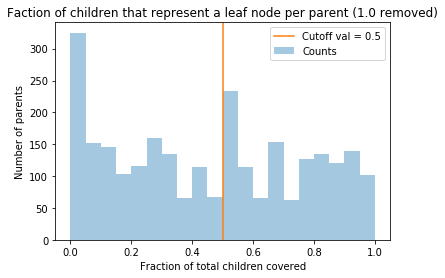

In [87]:
sns.distplot(saturation[saturation != 1], kde=False, bins=bins, label='Counts')
plt.axvline(frac, c=sns.color_palette()[1], label='Cutoff val = {:1.2g}'.format(frac))
plt.legend()
plt.xlabel('Fraction of total children covered')
plt.ylabel('Number of parents')
plt.title('Faction of children that represent a leaf node per parent (1.0 removed)');

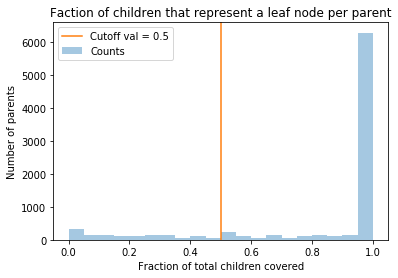

In [88]:
sns.distplot(saturation, kde=False, bins=bins, label='Counts')
plt.axvline(frac, c=sns.color_palette()[1], label='Cutoff val = {:1.2g}'.format(frac))
plt.legend()
plt.xlabel('Fraction of total children covered')
plt.ylabel('Number of parents')
plt.title('Faction of children that represent a leaf node per parent');

In [89]:
keep_for_map = leaf_maps[idx]['id'].tolist()
final_map = {k: list(v) for k, v in chebi_map.items() if k in keep_for_map}

go_to_chebi['tgt_child'] = go_to_chebi['tgt_id'].map(final_map)

go_to_chebi = expand_df_on_col(go_to_chebi, 'tgt_child')
len(go_to_chebi)

48529

In [90]:
id_to_network = pd.read_csv('../2_pipeline/09_Resolving_Chemical_Identifiers/out/compound_identifier_mapping.csv')
id_to_network.head(2)

,old_id,new_id,old_name,new_name
0,MESH:C533469,MESH:C533469,palomid 529,palomid 529
1,MESH:C006303,MESH:C006303,acivicin,acivicin


In [91]:
go_to_chebi.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tgt_child
0,GO:0035942,dehydroepiandrosterone secretion,transports_or_maintains_localization_of,CHEBI:28689,dehydroepiandrosterone,GO,CHEBI,NaN
1,GO:0046386,deoxyribose phosphate catabolic process,has_primary_input,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,NaN


In [92]:
# Some GO map directly to a compound
orig_edges = go_to_chebi.merge(id_to_network, left_on='tgt_id', right_on='old_id', how='inner')
# Other GO map to a compound class...
other_edges = (go_to_chebi.dropna(subset=['tgt_child'])
                          .merge(id_to_network, left_on='tgt_child', right_on='old_id', how='inner'))
go_to_cheb_edges = (pd.concat([orig_edges, other_edges], ignore_index=True)
                        .drop_duplicates(subset=['src_id', 'rel_type', 'new_id']))

In [93]:
len(go_to_cheb_edges)

6673

In [94]:
go_to_cheb_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tgt_child,old_id,new_id,old_name,new_name
0,GO:0046386,deoxyribose phosphate catabolic process,has_primary_input,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,NaN,CHEBI:19569,CHEBI:19569,2-deoxyribose phosphate,2-deoxyribose phosphate
1,GO:0046385,deoxyribose phosphate biosynthetic process,has_primary_output,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,NaN,CHEBI:19569,CHEBI:19569,2-deoxyribose phosphate,2-deoxyribose phosphate


In [95]:
go_to_cheb_edges['tgt_id'].nunique()

563

In [96]:
go_to_chebi['tgt_id'].nunique()

2072

In [97]:
go_to_cheb_edges['rel_type'].value_counts()

has_primary_input_or_output                1919
has_primary_output                         1661
has_primary_input                          1179
transports_or_maintains_localization_of     806
has_input                                   758
imports                                     131
regulates_level_of                           64
exports                                      55
has_output                                   48
has_intermediate                             36
has_participant                              12
has_part                                      4
Name: rel_type, dtype: int64

In [98]:
go_to_cheb_edges.head(2)

,src_id,src_name,rel_type,tgt_id,tgt_name,src_src,tgt_src,tgt_child,old_id,new_id,old_name,new_name
0,GO:0046386,deoxyribose phosphate catabolic process,has_primary_input,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,NaN,CHEBI:19569,CHEBI:19569,2-deoxyribose phosphate,2-deoxyribose phosphate
1,GO:0046385,deoxyribose phosphate biosynthetic process,has_primary_output,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,NaN,CHEBI:19569,CHEBI:19569,2-deoxyribose phosphate,2-deoxyribose phosphate


In [99]:
go_to_cheb_edges = edge_rename(go_to_cheb_edges.drop(['old_name', 'tgt_child', 'old_id'], axis=1),
                                tgt_id='orig_tgt', new_id='end_id', tgt_name='orig_name', new_name='tgt_name')

# Final edge processing

In [100]:
all_edges = [cl_to_pr_edges, cl_to_go_edges, cl_to_ub_edges, go_to_cl_edges, 
                 go_to_cheb_edges, go_to_ub_edges, ub_to_cl_edges, ub_to_go_edges]

In [101]:
cl_to_pr_edges.head(2)

,start_id,end_id,type,src_name,orig_tgt,orig_name,src_src,tgt_src,uniprot_id,uniprot_name,symbol,taxid
0,CL:0000037,930,lacks_plasma_membrane_part,hematopoietic stem cell,PR:000001002,CD19 molecule,CL,PR,P15391,CD19 molecule,CD19,9606.0
18,CL:0000094,930,lacks_plasma_membrane_part,granulocyte,PR:000001002,CD19 molecule,CL,PR,P15391,CD19 molecule,CD19,9606.0


In [102]:
go_to_cheb_edges.head(2)

,start_id,end_id,type,src_name,orig_tgt,orig_name,src_src,tgt_src,tgt_name
0,GO:0046386,CHEBI:19569,has_primary_input,deoxyribose phosphate catabolic process,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,2-deoxyribose phosphate
1,GO:0046385,CHEBI:19569,has_primary_output,deoxyribose phosphate biosynthetic process,CHEBI:19569,2-deoxyribose phosphate,GO,CHEBI,2-deoxyribose phosphate


In [103]:
all_edges = pd.concat(all_edges, ignore_index=True, sort=False)
len(all_edges)

12222

In [104]:
all_edges.head(2)

,start_id,end_id,type,src_name,orig_tgt,orig_name,src_src,tgt_src,uniprot_id,uniprot_name,symbol,taxid,tgt_name
0,CL:0000037,930,lacks_plasma_membrane_part,hematopoietic stem cell,PR:000001002,CD19 molecule,CL,PR,P15391,CD19 molecule,CD19,9606.0,NaN
1,CL:0000094,930,lacks_plasma_membrane_part,granulocyte,PR:000001002,CD19 molecule,CL,PR,P15391,CD19 molecule,CD19,9606.0,NaN


In [105]:
all_edges['type'].value_counts()

has_primary_input_or_output                       1919
has_primary_output                                1661
has_primary_input                                 1179
part_of                                            962
has_input                                          823
transports_or_maintains_localization_of            812
results_in_development_of                          686
has_plasma_membrane_part                           451
lacks_plasma_membrane_part                         419
capable_of                                         415
has_part                                           388
results_in_morphogenesis_of                        349
results_in_acquisition_of_features_of              299
occurs_in                                          206
results_in_formation_of                            188
imports                                            131
capable_of_part_of                                 122
composed_primarily_of                              112
results_in

In [106]:
all_edge_ids = set(all_edges['start_id']).union(set(all_edges['end_id']).union(all_edges['orig_tgt'].dropna()))

### Load in the nodes that we haven't used

In [107]:
cl_nodes = ot.get_ontology_nodes(data_dir.joinpath('cl.obo'), 'CL')
ub_nodes = ot.get_ontology_nodes(data_dir.joinpath('ext.obo'), 'UBERON')
hp_nodes = ot.get_ontology_nodes(data_dir.joinpath('hpo.obo'), 'HP')

In [108]:
# Special Processing for PR edges that became ENTREZ-Genes
drop_cols = ['start_id', 'src_name', 'src_src', 'tgt_src', 'tgt_name', 'type', 'orig_name']
rename_cols = {'end_id': 'id', 'uniprot_name': 'name', 'tgt_src': 'id_src', 'orig_tgt': 'pr_id'}

gene_nodes = all_edges.dropna(subset=['uniprot_id']).drop(drop_cols, axis=1).rename(columns=rename_cols)
gene_nodes['label'] = 'Gene'
gene_nodes['taxid'] = gene_nodes['taxid'].astype(int).astype(str)
gene_nodes = gt.order_cols(gene_nodes.drop_duplicates())
gene_nodes.sort_values('id').sample(5)

,id,name,label,pr_id,uniprot_id,symbol,taxid
296,6688,Spi-1 proto-oncogene,Gene,PR:000001944,P17947,SPI1,9606
502,7070,Thy-1 cell surface antigen,Gene,PR:000001843,P04216,THY1,9606
508,7037,transferrin receptor,Gene,PR:000001945,P02786,TFRC,9606
906,5896,recombination activating 1,Gene,PR:000003457,P15918,RAG1,9606
205,925,CD8a molecule,Gene,PR:000025403,P01732,CD8A,9606


In [109]:
# Special Processing for PR edges that became ENTREZ-Genes
drop_cols = ['start_id', 'src_name', 'src_src', 'tgt_src', 'tgt_name', 'type', 'orig_name']
rename_cols = {'end_id': 'id', 'uniprot_name': 'name', 'tgt_src': 'id_src', 'orig_tgt': 'pr_id'}

gene_nodes = all_edges.dropna(subset=['uniprot_id']).drop(drop_cols, axis=1).rename(columns=rename_cols)
gene_nodes['label'] = 'Gene'
gene_nodes['taxid'] = gene_nodes['taxid'].astype(int).astype(str)
gene_nodes = gt.order_cols(gene_nodes.drop_duplicates())
gene_nodes.sort_values('id').sample(5)

,id,name,label,pr_id,uniprot_id,symbol,taxid
804,9308,CD83 molecule,Gene,PR:000001310,Q01151,CD83,9606
792,942,CD86 molecule,Gene,PR:000001412,P42081,CD86,9606
785,5079,paired box 5,Gene,PR:000001903,Q02548,PAX5,9606
789,3695,integrin subunit beta 7,Gene,PR:000009143,P26010,ITGB7,9606
991,684,bone marrow stromal cell antigen 2,Gene,PR:000001326,Q10589,BST2,9606


In [110]:
pr_nodes['label'] = 'Gene'
cl_nodes['label'] = 'Cell Type'
chebi_nodes['label'] = 'Compound'
ub_nodes['label'] = 'Anatomy'
hp_nodes['label'] = 'Phenotype'
go_nodes['label'] = go_nodes['hasOBONamespace'].str.replace('_', ' ').str.title()

all_nodes = pd.concat([go_nodes.query('id_src == "GO"'), ok_pr_nodes, cl_nodes, 
                       chebi_nodes.query('id_src == "CHEBI"'), 
                       ub_nodes, hp_nodes, gene_nodes], ignore_index=True, sort=False)

In [111]:
len(all_nodes)

296117

In [112]:
nodes_filt = all_nodes.query('id in @all_edge_ids').reset_index(drop=True)
len(nodes_filt)

9749

In [113]:
num_nogo = len(nodes_filt.query('id_src != "GO"'))
bad_cols = nodes_filt.query('id_src != "GO"').isnull().sum() == num_nogo
bad_cols = bad_cols[bad_cols].index.tolist()
bad_cols

['type',
 'xrefs',
 'deprecated',
 'date',
 'definition',
 'subsets',
 'synonyms',
 'IAO:0000231',
 'IAO:0000425',
 'IAO:0000589',
 'IAO:0100001',
 'RO:0002161',
 'comments',
 'consider',
 'created:by',
 'creation:date',
 'creator',
 'hasAlternativeId',
 'hasOBONamespace',
 'hasScope',
 'is:class:level',
 'is:metadata:tag',
 'shorthand',
 'replaced_by']

In [114]:
nodes_filt = gt.order_cols(nodes_filt.drop(bad_cols, axis=1))
nodes_filt.sample(10)

,id,name,label,id_src,alt_id,def,is_obsolete,xref,id_part,creation_date,subset,ikey,pr_id,uniprot_id,symbol,taxid
2372,GO:0019882,antigen processing and presentation,Biological Process,GO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518,GO:0003039,detection of reduced oxygen by carotid body ch...,Biological Process,GO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7629,CHEBI:17187,pinene,Compound,CHEBI,CHEBI:8215|CHEBI:26134|CHEBI:14839,NaN,False,KEGG:C06077,NaN,NaN,3_STAR,NaN,NaN,NaN,NaN,NaN
6293,CHEBI:48063,(R)-3-hydroxy-L-glutamic acid,Compound,CHEBI,NaN,NaN,False,"Beilstein:1725027 ""Beilstein""",NaN,NaN,3_STAR,LKZIEAUIOCGXBY-FONMRSAGSA-N,NaN,NaN,NaN,NaN
5900,CL:2000024,spinal cord medial motor column neuron,Cell Type,NaN,NaN,"""Any neuron that is part of a spinal cord medi...",False,NaN,NaN,2014-06-25T00:23:43Z,NaN,NaN,NaN,NaN,NaN,NaN
3452,GO:0072231,metanephric proximal convoluted tubule segment...,Biological Process,GO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5532,CL:0010006,cardiac blood vessel endothelial cell,Cell Type,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8748,UBERON:0002540,lateral line system,Anatomy,NaN,NaN,"""A line of sensory organs and associated struc...",False,AAO:0000269|AAO:0000975|EFO:0000941|http://en....,NaN,NaN,efo_slim|uberon_slim,NaN,NaN,NaN,NaN,NaN
773,GO:0006230,TMP biosynthetic process,Biological Process,GO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5668,CL:1000398,endothelial cell of hepatic sinusoid,Cell Type,NaN,NaN,"""An endothelial cell that is part of the hepat...",False,FMA:62911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
all_nodes = gt.order_cols(all_nodes.drop(bad_cols, axis=1))

In [116]:
print(len(all_nodes), len(nodes_filt), len(all_edges))

296117 9749 12222


In [117]:
all_nodes.to_csv(out_dir.joinpath('all_onto_nodes.csv'), index=False)
nodes_filt.to_csv(out_dir.joinpath('filt_onto_nodes.csv'), index=False)
all_edges.to_csv(out_dir.joinpath('onto_edges.csv'), index=False)

## Testing some GO mappings...

In [118]:
go_map = ot.get_children_map(go_edges.query('src_src == "GO" and tgt_src == "GO"'))

In [119]:
go_non_leaves = list(go_map.keys())
go_leaves = go_nodes.query('id_src == "GO" and id not in @go_non_leaves')['id'].tolist()
len(go_leaves)

32319

In [120]:
go_lv2 = get_subset_onto_levels(go_edges.query('src_src == "GO" and tgt_src == "GO"'), go_leaves, 'up', 3)

In [121]:
len(go_lv2)

76479

In [122]:
len(go_edges.query('src_src == "GO" and tgt_src == "GO"'))

98251

In [123]:
go_lv2_map = ot.get_children_map(go_lv2)

In [124]:
# 
map_go_vals = pd.DataFrame({'parent': list(chain(*[[k]*len(v) for k, v in go_lv2_map.items()])),
              'child': list(chain(*[v for v in go_lv2_map.values()]))}).groupby('parent').apply(len)

total_go_vals = pd.DataFrame({'parent': list(chain(*[[k]*len(v) for k, v in go_map.items()])),
              'child': list(chain(*[v for v in go_map.values()]))}).groupby('parent').apply(len)

leaf_go_maps = (pd.concat([map_go_vals, total_go_vals], axis=1, sort=False)
                    .rename(columns={0:'lv2_children', 1:'total_children'})
                    .dropna(subset=['lv2_children']))

col_name = 'parent' if len(map_go_vals) == len(total_go_vals) else 'index'

leaf_go_maps = leaf_go_maps.reset_index().rename(columns={col_name: 'id'})
leaf_go_maps['name'] = leaf_go_maps['id'].map(go_nodes.set_index('id')['name'].to_dict())
leaf_go_maps.head(2)

,id,lv2_children,total_children,name
0,GO:0000002,1.0,1,mitochondrial genome maintenance
1,GO:0000003,32.0,32,reproduction


In [125]:
go_saturation = leaf_go_maps['lv2_children'] / leaf_go_maps['total_children'] 
leaf_go_maps['saturation'] = go_saturation
leaf_go_maps.sort_values('saturation').head(30)

,id,lv2_children,total_children,name,saturation
10660,GO:0052128,1.0,14,positive energy taxis,0.071429
10661,GO:0052129,1.0,14,negative energy taxis,0.071429
11083,GO:0055117,2.0,25,regulation of cardiac muscle contraction,0.080000
8350,GO:0044362,6.0,55,negative regulation of molecular function in o...,0.109091
1575,GO:0006074,1.0,8,(1->3)-beta-D-glucan metabolic process,0.125000
5043,GO:0030004,3.0,22,cellular monovalent inorganic cation homeostasis,0.136364
17055,GO:2000381,2.0,14,negative regulation of mesoderm development,0.142857
17056,GO:2000382,2.0,14,positive regulation of mesoderm development,0.142857
11071,GO:0055086,99.0,644,nucleobase-containing small molecule metabolic...,0.153727
11779,GO:0070085,9.0,56,glycosylation,0.160714


These all look like pretty specific terms still, yet the have tons of children that aren't in the network

GO must be both tall and connected... with too many branching paths of varying length from the node too the root.. I don't think this strategy will work for GO